<a href="https://colab.research.google.com/github/Abhishek-P/bert-trials/blob/main/Fine_tuning_BERT-TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning BERT
Based on the tutorial from http://mccormickml.com/2019/07/22/BERT-fine-tuning/#11-using-colab-gpu-for-training

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("There are %d GPUs available" % torch.cuda.device_count())
  print(' We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print(' No GPU available, using CPU instead')
  device = torch.device('cpu')

There are 1 GPUs available
 We will use the GPU: Tesla T4


In [3]:
is_colab = False
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  is_colab = True
else:
  print('Not running on CoLab')

Running on CoLab


In [4]:
if is_colab:
    %pwd
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    print("Mounted Drive successfully")
    %cd /content
    %cd /content/gdrive/My\ Drive/abhip-models/
    print("Should be in the drive folder of the project, check previous printed line to confirm")

Mounted at /content/gdrive
Mounted Drive successfully
/content
/content/gdrive/My Drive/abhip-models
Should be in the drive folder of the project, check previous printed line to confirm


In [5]:
!pip install transformers

     |████████████████████████████████| 1.0MB 5.3MB/s 
     |████████████████████████████████| 890kB 38.0MB/s 
     |████████████████████████████████| 1.1MB 40.7MB/s 
     |████████████████████████████████| 3.0MB 37.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8ceecf61299e0ce926fcb9d8b383173e2c79f101d698b009699578a998bb02e2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


I don't expect to have consistent runtime for the work and would be useful to keep them in peristent storage in My Drive

In [6]:
%pwd

'/content/gdrive/My Drive/abhip-models'

In [7]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=85a77cc5ef7b8c3e1e2335e3f519d4ad0d3d7c4209467804807eb3384a4c47d5
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [8]:
import wget
import os

print('Downloading the dataset')
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
  try: 
    wget.download(url, './cola_public_1.1.zip')
  except Exception as e:
    print("Failed to use py wget")
    print(e)


In [9]:
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [10]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv",  delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
7154,sks13,1,NaN,"This girl will not buy bread, will she buy bread?"
2419,l-93,0,*,The new tax Jaws will gain the middle class.
6488,d_98,1,NaN,John liked everything that was placed before him.
4455,ks08,0,*,I found myself doing need sleep.
4061,ks08,0,*,We hope the availability of such a vaccine in ...
5808,c_13,1,NaN,George wrote a volume of poems in Latin for Jane.
2377,l-93,1,NaN,I admired him for his honesty.
163,cj99,1,NaN,Mary gets depressed and she listens to the Gra...
2467,l-93,1,NaN,In this cave was found an ancient treasure trove.
2405,l-93,1,NaN,I incorporated the new results into the paper.


In [11]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
2485,The cook boned the fish of its backbone.,0
2530,Jennifer craned her arm.,0
7892,Bill's reading Shakespeare and Maureen's singi...,0
3188,She always clad herself in black.,0
5791,the book with a red cover from Blackwell by Ro...,0


In [12]:
sentences = df.sentence.values
labels = df.label.values

In [13]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [14]:
print('Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [15]:
max_len = 0
for sent in sentences:
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  max_len = max(max_len, len(input_ids))
print("Max length:", max_len)

Max length: 47


In [16]:
if  (not os.path.exists('./input_ids.pt')) or (not os.path.exists('./attention_masks.pt')) or (not os.path.exists('./labels.pt')):
  input_ids =[]
  attention_masks = []

  for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True, 
        max_length = 64,
        pad_to_max_length = True,
        return_attention_mask = True, 
        return_tensors = 'pt'
    )

    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  torch.save(input_ids, 'input_ids.pt')
  torch.save(attention_masks, 'attention_masks.pt')
  torch.save(labels, 'labels.pt')


  print('Original:  ', sentences[0])
  print('Token IDs: ', input_ids[0])
else:
  print("Loading the tensors from Drive")
  input_ids = torch.load('./input_ids.pt')
  attention_masks = torch.load('./attention_masks.pt')
  labels = torch.load('./labels.pt')

Loading the tensors from Drive


In [17]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


7,695 training samples
  856 validation samples


In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, 
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)



In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [21]:
optimizer = AdamW(
    model.parameters(),
    lr  = 2e-5,
    eps =  1e-8
)

In [22]:
from transformers import get_linear_schedule_with_warmup
epochs = 4

total_steps = len(train_dataloader) * epochs;

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps =0,
                                           num_training_steps = total_steps)

In [23]:
import numpy as np
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
# Training Loop
import random
import numpy as np

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i +1, epochs))
  print('Training...')


  t0 = time.time()

  total_train_loss = 0
  # Put it into training mode
  model.train()

  for step, batch in enumerate(train_dataloader):
    if step%40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print('Batch {:>5}  of  {:>5}.   Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      model.zero_grad()

      loss, logits = model(b_input_ids,
                           token_type_ids = None,
                           attention_mask = b_input_mask, 
                           labels = b_labels)

      total_train_loss += loss.item()

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()

      scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)

  training_time = format_time(time.time() - t0)

  print("")
  print(" Average training loss {0:.2f}".format(avg_train_loss))
  print(" Training epoch took: {:}".format(training_time))

  print("")
  print("Running Validation...")


  t0 = time.time()

  model.eval()

  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
      (loss, logits) = model(b_input_ids,
                             token_type_ids = None, 
                             attention_mask = b_input_mask,
                             labels = b_labels)
      
    total_eval_loss =+ loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    total_eval_accuracy += flat_accuracy(logits, label_ids)
  

  avg_val_accuracy = total_eval_accuracy/ len(validation_dataloader)
  print(" Accuracy: {0:.2f}".format(avg_val_accuracy))

  avg_val_loss = total_eval_loss/ len(validation_dataloader)
  validation_time = format_time(time.time() - t0)
  print(" Validation Loss: {0:.2f}".format(avg_val_loss))
  print(" Validation took: {:}".format(validation_time))

  training_stats.append(
      {
          'epoch': epoch_i + 1,
       'Training Loss': avg_train_loss,
       'Valid. Loss': avg_val_loss,
       'Valid. Accur.': avg_val_accuracy,
       'Training Time': training_time,
       'Validation Time': validation_time
      }
  )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))



======== Epoch 1 / 4 ========
Training...
Batch    40  of    241.   Elapsed: 0:00:00.
Batch    80  of    241.   Elapsed: 0:00:01.
Batch   120  of    241.   Elapsed: 0:00:01.
Batch   160  of    241.   Elapsed: 0:00:01.
Batch   200  of    241.   Elapsed: 0:00:02.
Batch   240  of    241.   Elapsed: 0:00:02.

 Average training loss 0.02
 Training epoch took: 0:00:02

Running Validation...
 Accuracy: 0.71
 Validation Loss: 0.02
 Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
Batch    40  of    241.   Elapsed: 0:00:00.
Batch    80  of    241.   Elapsed: 0:00:00.
Batch   120  of    241.   Elapsed: 0:00:01.
Batch   160  of    241.   Elapsed: 0:00:01.
Batch   200  of    241.   Elapsed: 0:00:01.
Batch   240  of    241.   Elapsed: 0:00:02.

 Average training loss 0.02
 Training epoch took: 0:00:02

Running Validation...
 Accuracy: 0.71
 Validation Loss: 0.02
 Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
Batch    40  of    241.   Elapsed: 0:00:00.
Batch

In [26]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.02,0.02,0.71,0:00:02,0:00:03
2,0.02,0.02,0.71,0:00:02,0:00:03
3,0.02,0.02,0.71,0:00:02,0:00:03
4,0.02,0.02,0.71,0:00:02,0:00:03


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


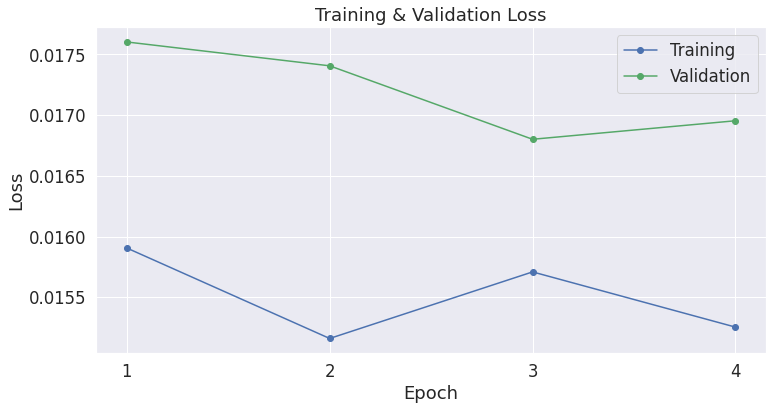

In [27]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4])

plt.show()

In [28]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter = "\t", header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []


for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
      sent, 
      add_special_tokens = True,
      max_length = 64, 
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  
  input_ids.append(encoded_dict['input_ids'])

  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size = batch_size)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitely activated but `max_length` is provided a specific value, please use

Number of test sentences: 516



Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

In [29]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
model.eval()

predictions, true_labels =[], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids= None, attention_mask = b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)


print('DONE.')
print(len(predictions))

Predicting labels for 516 test sentences...
DONE.
17


In [30]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum())/ len(df.label) * 100))

Positive samples: 354 of 516 (68.60%)


In [31]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

print('Calculating Mattews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

print(matthews_set)

Calculating Mattews Corr. Coef. for each batch...
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [32]:
ax = sns.barplot(x = list(range(len(matthews_set))), y = matthews_set, ci = )

plt.title(' MCC Score per batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

SyntaxError: ignored

In [ ]:
 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)
